# Prediction using glmnet 

In [ ]:
library(data.table)
library(caret)
library(pROC)
library(randomForest)
load("projetdatascience.rda")

##### getting the emptiness ratio and number of factors foreach column and save the information in dataframe

In [2]:
vec_names         = names(projetTrain)
nb_lignes         = nrow(projetTrain)
vec_taux          = rep(0,length(vec_names))
vec_factors       = rep(0,length(vec_names))
index             = 1
data.informations = data.table(
                         feature=vec_names, 
                         taux=vec_taux,
                         factors=vec_factors
                        )


for(name in data.informations$feature){
    data.informations[index,  taux := (sum( is.na(projetTrain[,name, with=FALSE])) / nb_lignes)*100] 
    data.informations[index,factors:= length(table(projetTrain[,name, with=FALSE]))]
    index=index+1
}

##### saving in vectors the columns to factorise and the ones to drop 

In [4]:
columnsToFactor = data.informations[factors<10]$feature
columnsToDrop   = data.informations[taux>17]$feature

In [5]:
projetTrain = projetTrain[,target:=ifelse(target==1,"OK","KO")] # transforming target from 1 0 to OK and KO

##### factorisation of columns that contains less than 10 unique values


In [6]:
for (feature in columnsToFactor) {    
    if(feature != "target" ) { 
        projetValid[,feature:=as.factor(get(feature)),with=FALSE]
    }
    projetTrain[,feature:=as.factor(get(feature)),with=FALSE]
}
projetTrain$Product_Info_2 = as.factor(projetTrain$Product_Info_2)
projetValid$Product_Info_2 = as.factor(projetValid$Product_Info_2)

##### filling NA values 

In [7]:
projetTrainClean = na.roughfix(projetTrain)

##### making subsets for train and test

In [8]:
set.seed(30)
split = sample(nrow(projetTrainClean), floor(0.7*nrow(projetTrainClean)))
sub.train = projetTrainClean[split,]
sub.test  = projetTrainClean[-split,]

In [43]:
lambda.grid = seq(0.005,0.007,length=10)
alpha.grid  = seq(0.43,0.6,length=10)
srchGrid    = expand.grid(.alpha=alpha.grid,.lambda=lambda.grid)
trnCtl      = trainControl(method="repeatedCV",number=10,repeats=2) # cadrage coss valisation

In [44]:
glmnet.model = train(target~.,data=sub.train,method="glmnet",tuneGrid=srchGrid,trControl=trnCtl,standardize=TRUE)#,maxit=1000000)

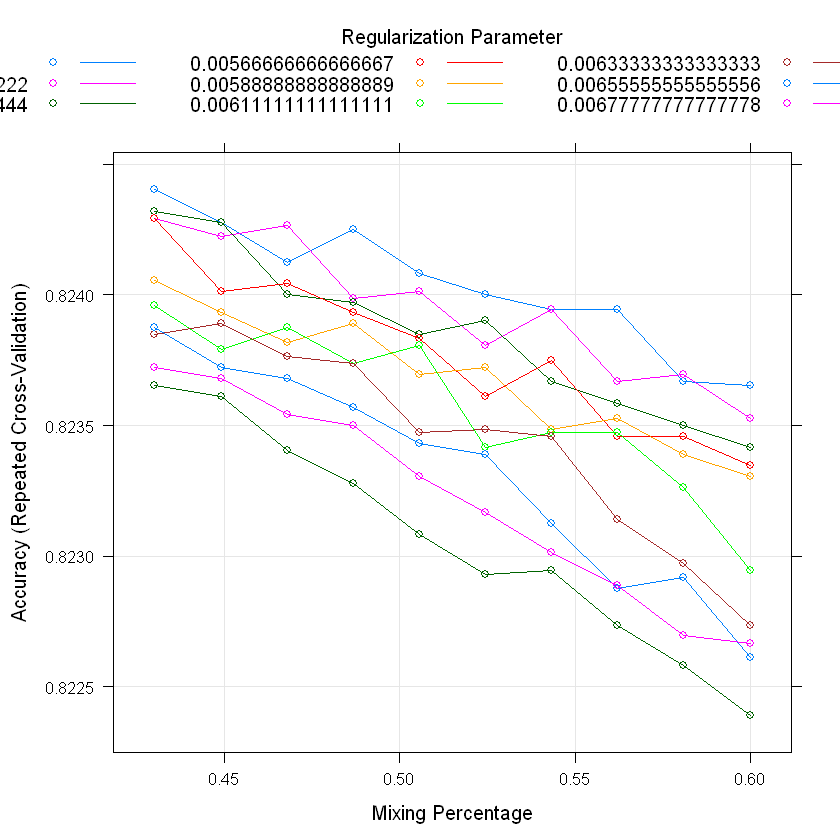

In [45]:
plot(glmnet.model) # visialusation des performances pour les diffï¿½rentes valeurs de alpha et beta"

##### model description

In [47]:
glmnet.model

glmnet 

35966 samples
  127 predictor
    2 classes: 'KO', 'OK' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 2 times) 
Summary of sample sizes: 32370, 32369, 32370, 32370, 32369, 32369, ... 
Resampling results across tuning parameters:

  alpha      lambda       Accuracy   Kappa    
  0.4300000  0.005000000  0.8244037  0.5986807
  0.4300000  0.005222222  0.8242925  0.5983608
  0.4300000  0.005444444  0.8243203  0.5983039
  0.4300000  0.005666667  0.8242925  0.5981033
  0.4300000  0.005888889  0.8240561  0.5974443
  0.4300000  0.006111111  0.8239588  0.5971305
  0.4300000  0.006333333  0.8238476  0.5967409
  0.4300000  0.006555556  0.8238754  0.5966543
  0.4300000  0.006777778  0.8237225  0.5962479
  0.4300000  0.007000000  0.8236530  0.5959601
  0.4488889  0.005000000  0.8242786  0.5983428
  0.4488889  0.005222222  0.8242230  0.5981015
  0.4488889  0.005444444  0.8242786  0.5981535
  0.4488889  0.005666667  0.8240144  0.5974225
  0.4488889  0.005888889  0.8239310

In [48]:
result.predicted.prob <- predict(glmnet.model, sub.test , type="prob") # Prediction


Call:
roc.default(response = sub.test$target, predictor = result.predicted.prob$OK)

Data: result.predicted.prob$OK in 10373 controls (sub.test$target KO) < 5042 cases (sub.test$target OK).
Area under the curve: 0.8993

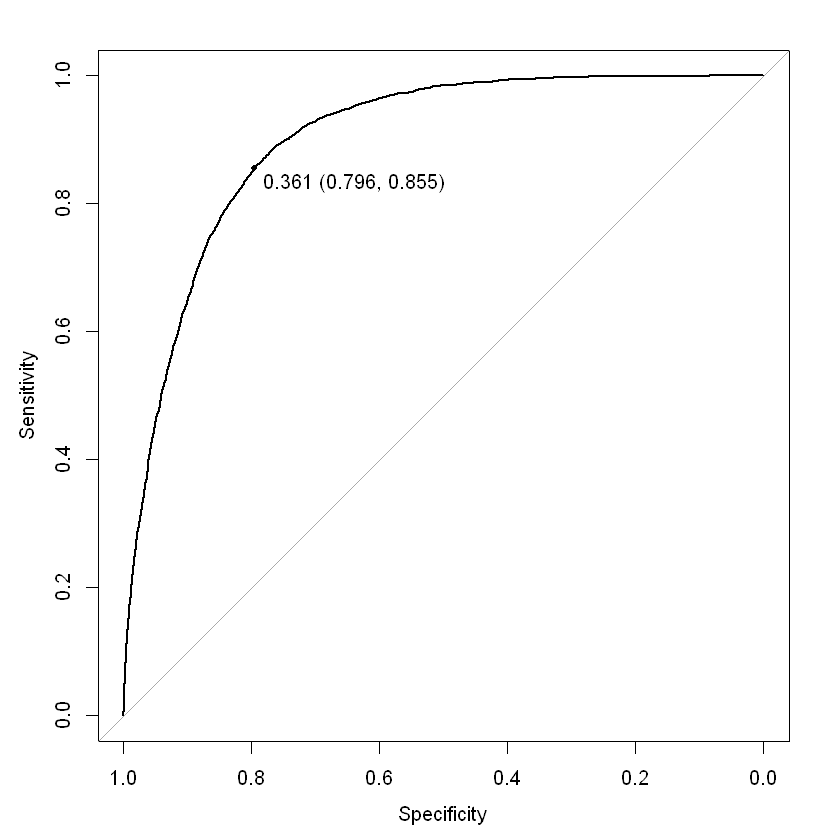

In [49]:
result.roc <- roc(sub.test$target, result.predicted.prob$OK) # Draw ROC curve.
plot(result.roc, print.thres="best", print.thres.best.method="closest.topleft")

##### creating columns 

* split the column prodcut info 2 in columns to isolate the letter and the level wheter it's A B C or 1 2 3 etc .. 
* creates columns where there will be the log, the x², the exp of the numerical columns existing in the dataset
* multiplication of columns that works well together but before, we should check if they work well together. 
